In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [3]:
import numpy as np
import pandas as pd
train_df=pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_df=pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')


In [4]:
train_df.shape

(100000, 76)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 75 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           10000 non-null  object 
 1   ProductName                         10000 non-null  object 
 2   EngineVersion                       10000 non-null  object 
 3   AppVersion                          10000 non-null  object 
 4   SignatureVersion                    10000 non-null  object 
 5   IsBetaUser                          10000 non-null  int64  
 6   RealTimeProtectionState             9991 non-null   float64
 7   IsPassiveModeEnabled                10000 non-null  int64  
 8   AntivirusConfigID                   9998 non-null   float64
 9   NumAntivirusProductsInstalled       9998 non-null   float64
 10  NumAntivirusProductsEnabled         9998 non-null   float64
 11  HasTpm                              10000 

In [7]:
# Check for missing values
print(train_df.isnull().sum())

print(test_df.isnull().sum())


MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64
MachineID                            0
ProductName                          0
EngineVersion                        0
AppVersion                           0
SignatureVersion                     0
                                    ..
IsAlwaysOnAlwaysConnectedCapable    12
IsGamer                             62
RegionIdentifier                    62
DateAS                               0
DateOS                               3
Length: 75, dtype: int64


In [8]:
# Summary statistics

print(train_df.describe())

print(test_df.describe())


       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000         

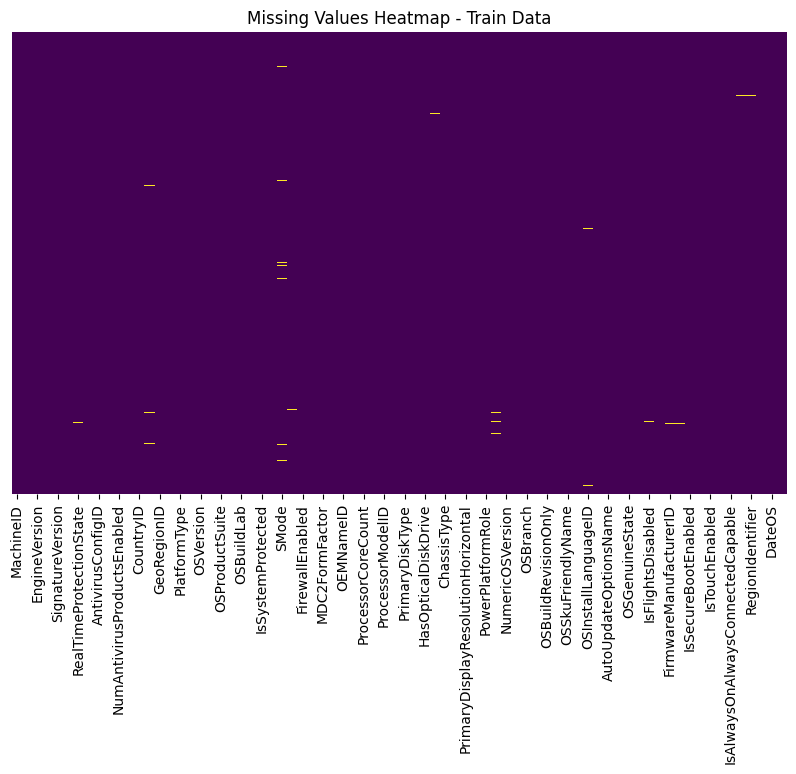

In [4]:
# Visualizing missing data
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap - Train Data")
plt.show()


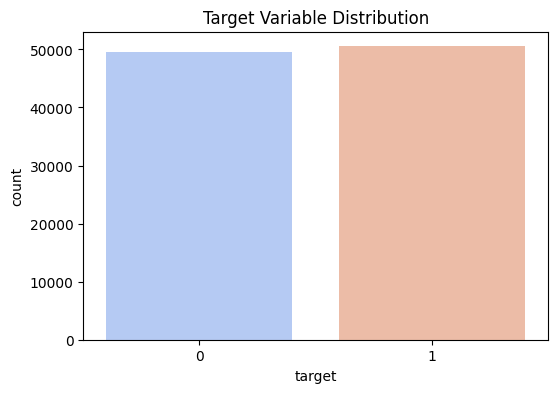

In [5]:
# Checking class distribution (assuming target column is named 'target')
if 'target' in train_df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=train_df['target'], palette='coolwarm')
    plt.title("Target Variable Distribution")
    plt.show()

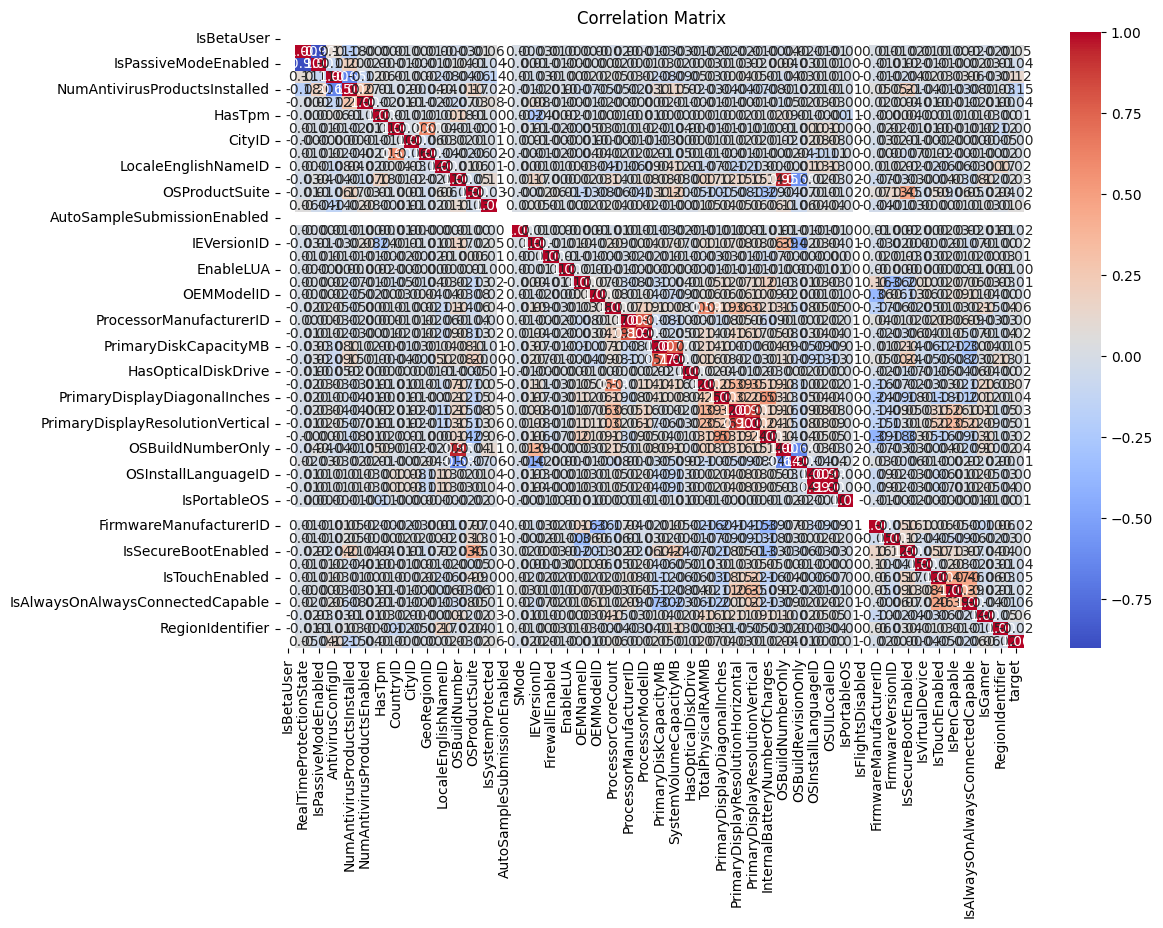

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Matrix")
plt.show()


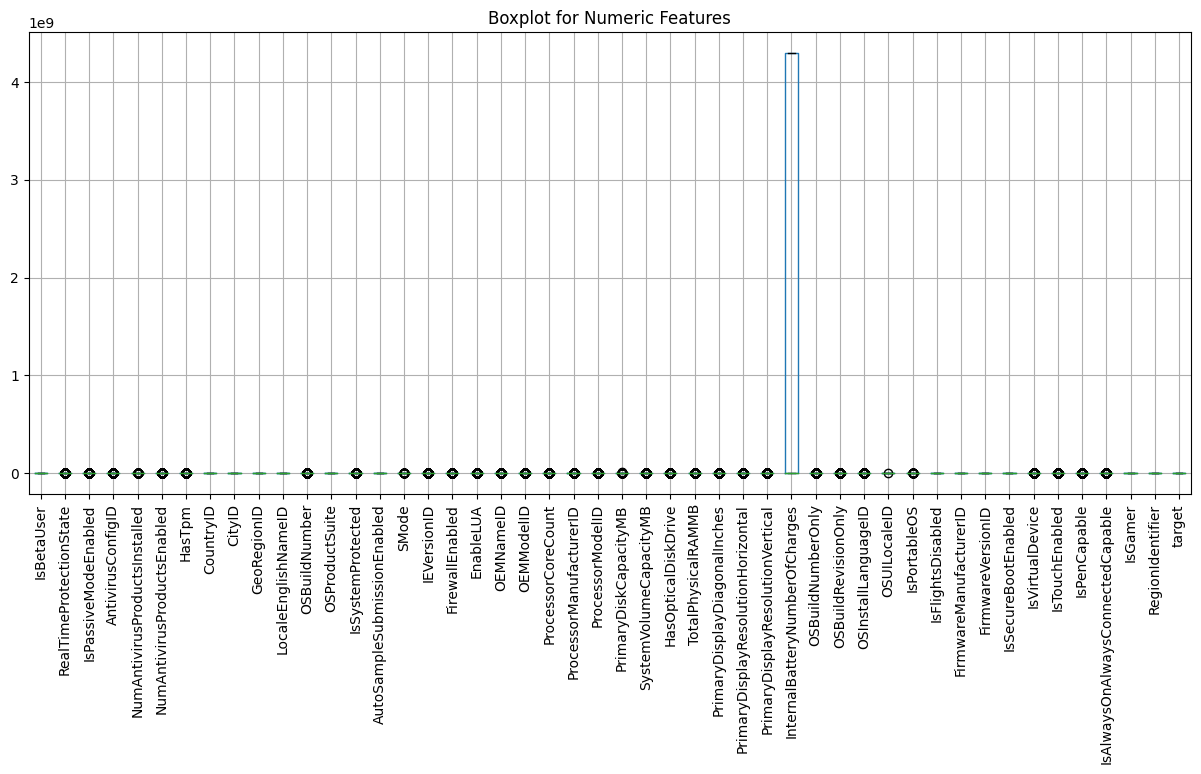

In [7]:
# Detecting outliers using box plots
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(15, 6))
train_df[numeric_cols].boxplot(rot=90)
plt.title("Boxplot for Numeric Features")
plt.show()


In [8]:
# Detecting outliers using Z-score
z_scores = np.abs(stats.zscore(train_df[numeric_cols]))
threshold = 3
outlier_rows = np.where(z_scores > threshold)
print("\nNumber of Outliers Detected:", len(outlier_rows[0]))



Number of Outliers Detected: 22211


In [9]:
# Handling outliers (Clipping values beyond 3 standard deviations)
train_df[numeric_cols] = train_df[numeric_cols].apply(lambda x: np.clip(x, x.quantile(0.01), x.quantile(0.99)))


In [10]:
# Identifying categorical and numerical features
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('target') if 'target' in numerical_features else None


In [11]:
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    label_encoders[col] = le


In [12]:
# Feature Selection: Removing highly correlated features
corr_matrix = train_df[numerical_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
train_df.drop(columns=to_drop, inplace=True)
test_df.drop(columns=to_drop, inplace=True)
numerical_features = [col for col in numerical_features if col not in to_drop]


In [13]:
# Handling missing values and scaling numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features)
])


In [14]:
X = train_df.drop(columns=['target'])
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(test_df)

In [15]:
X_train.shape

(80000, 43)

In [16]:
#svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
rfc_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
# xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}

In [17]:
#svc = GridSearchCV(SVC(probability=True), svc_params, cv=3, scoring='roc_auc')
rfc = GridSearchCV(RandomForestClassifier(), rfc_params, cv=3, scoring='roc_auc')
#xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=3, scoring='roc_auc')


In [22]:
#svc.fit(X_train, y_train)
# rfc.fit(X_train, y_train)
#xgb.fit(X_train, y_train)


In [24]:
rfc.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# print("\nBest Parameters:")
# print("SVC:", svc.best_params_)
# print("Random Forest:", rfc.best_params_)
# print("XGBoost:", xgb.best_params_)


In [25]:
def evaluate_model(model, X_val, y_val, name):
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    print(f"{name} - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    print(f"\nClassification Report for {name}:\n", classification_report(y_val, y_pred))
    print(f"\nConfusion Matrix for {name}:\n", confusion_matrix(y_val, y_pred))

print("\nModel Performance:")


Model Performance:


In [ ]:
test_df.shape

In [ ]:
#evaluate_model(xgb.best_estimator_, X_val, y_val, "XGBoost Classifier")

In [26]:
evaluate_model(rfc.best_estimator_, X_val, y_val, "Random Forest Classifier")

Random Forest Classifier - Accuracy: 0.6062, ROC AUC: 0.6418

Classification Report for Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.62      0.51      0.56      9878
           1       0.59      0.70      0.64     10122

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.60     20000
weighted avg       0.61      0.61      0.60     20000


Confusion Matrix for Random Forest Classifier:
 [[5069 4809]
 [3066 7056]]


In [ ]:
#test_predictions = xgb.best_estimator_.predict(X_test)

In [27]:
test_predictions = rfc.best_estimator_.predict(X_test)

In [28]:
submission = pd.DataFrame({"id": range(0, test_df.shape[0]), "target": test_predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file generated successfully.")


Submission file generated successfully.
